In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils import graph
from utils import utils
from nodes.node_functions import *

In [2]:
from utils.utils import get_user_input

In [18]:
import numpy as np

# playground

# setup

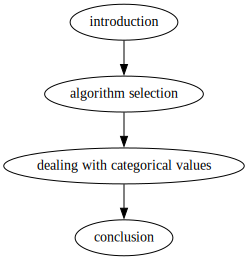

In [2]:
interview_graph = graph.create_interview_flowchart()

graph.plot_graph(interview_graph)

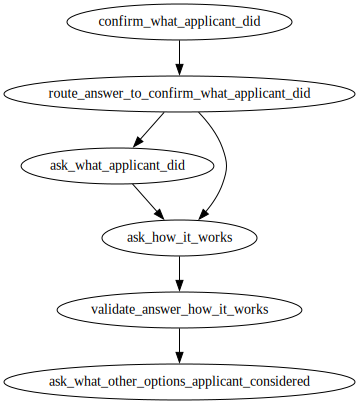

In [3]:
graph.plot_graph(interview_graph.nodes["algorithm selection"]['graph'])

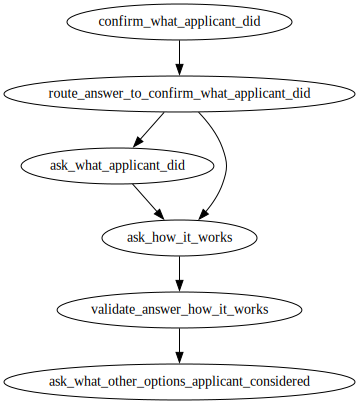

In [4]:
graph.plot_graph(interview_graph.nodes["dealing with categorical values"]['graph'])

In [5]:
def identify_what_applicant_has_done_in_ipynb():
    applicant_approaches = {
        'algorithm selection': 'Feedforward neural net',
        'categorical encoding': 'target encoding'
    }
    applicant_approaches_json = json.dumps(applicant_approaches)
    return applicant_approaches_json

what_applicant_has_done_in_ipynb = identify_what_applicant_has_done_in_ipynb()
what_applicant_has_done_in_ipynb

interview_graph.nodes["algorithm selection"]['graph'].nodes['confirm_what_applicant_did']['function_args']['context'] = what_applicant_has_done_in_ipynb
interview_graph.nodes["dealing with categorical values"]['graph'].nodes['confirm_what_applicant_did']['function_args']['context'] = what_applicant_has_done_in_ipynb

In [5]:
# interview_graph.nodes["algorithm selection"]['graph'].nodes['ask_how_it_works']['function_args']['subject'] = "DBSCAN"

# current_node = interview_graph.nodes["dealing with categorical values"]['graph'].nodes["ask_how_it_works"]

# # section_graph = interview_graph.nodes["dealing with categorical values"]['graph']
# # [n for n,d in section_graph.in_degree() if d==0] 

# current_node_function_args = deepcopy(current_node['function_args'])
# current_node_function_args['carryover_data'] = dict(algorithm_selection=dict(subject='Ordinal encoding'))
# current_node_function_args['chat_history_by_section'] = [[]]

# current_node_output = current_node['function'](**current_node_function_args)

# run

In [6]:
# chat

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = []
flattened_chat_history = ""

# list of the nodes that have been visited till the current point
sections_visited_names = []
nodes_visited_names = []

validate_async = False

is_interview_complete = False

carryover_data = {
# "dealing with categorical values": {
#     "ask_how_it_works": {
#         "subject": "hash encoding"
#     }
# },
# "algorithm selection": {
#     "ask_what_you_did": {
#         "subject": ""
#     }
# }
}

def get_first_node_in_graph(graph):
    first_node_name = [node_name for node_name, in_degrees in graph.in_degree() if in_degrees==0][0]
    first_node = graph.nodes[first_node_name]
    return first_node_name, first_node

def get_next_node(graph, current_node_name, current_node_output):
    outgoing_edges = list(graph.out_edges(current_node_name, data=True))
    if len(outgoing_edges) == 0:
        return None, None
    else:
        if len(outgoing_edges) == 1:
            edge_to_traverse = outgoing_edges[0]
        else:
            for edge in outgoing_edges:
                if current_node_output['routing_value'] in edge[-1]['passthrough_values']:
                    edge_to_traverse = edge
        next_node_name = edge_to_traverse[1]
        next_node = graph.nodes[next_node_name]
        return next_node_name, next_node
    
current_section_name, current_section = get_first_node_in_graph(interview_graph)
current_section_graph = current_section['graph']

In [7]:


# traverse through sections
while not is_interview_complete:
    chat_history_by_section.append([])
    current_node_name, current_node = get_first_node_in_graph(current_section_graph)
    # print("\n\ncurrent section: " + current_section_name)
    # print("current node: " + current_node_name)
    is_section_complete = False
    # traverse within section
    while not is_section_complete:
        # access current node from current section
        # prep args for current node function
        current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
        current_node_function_args['current_section_name'] = current_section_name
        # current_node_function_args['current_node_name'] = current_node_name
        current_node_function_args['carryover_data'] = carryover_data
        current_node_function_args['validate_async'] = validate_async
        current_node_function_args['chat_history_by_section'] = chat_history_by_section

        # call function
        current_node_output = current_node['function'](**current_node_function_args)
        
        if current_node_output['new_chat_lines']:
            # store return values in appropriate variables (chat_history)
            chat_history_by_section[-1].extend(current_node_output['new_chat_lines'])
            flattened_chat_history += "\n" + "\n".join(current_node_output['new_chat_lines'])
            clear_output()
            print(flattened_chat_history)
    
        # update nodes_visited
        nodes_visited_names.append(current_node_name)
    
        # figure out next node to visit
        current_node_name, current_node = get_next_node(current_section_graph, current_node_name, current_node_output)
        if current_node_name is None:
            # prepare routing_value (result of a section)
            current_section_output = dict(routing_value=1, 
                                          new_chat_line=None) 
            is_section_complete = True

    
    sections_visited_names.append(current_section_name)
    # get new section
    current_section_name, current_section = get_next_node(interview_graph, current_section_name, current_section_output)
    if current_section_name is None:
        is_interview_complete = True
        break
    current_section_graph = current_section['graph']



******************
********* Model Name *********
route_answer_to_confirm_what_applicant_did
********* Prompt *********
Current section chat:
Interviewer: I see that you used Target Encoding to encode your categorical values. Could you confirm that?
Applicant: Yup

Details:
Is routing correct: 1
###

********* Completion *********
Route: 1
******************



Do you want to validate this observation now? (1/0):  `


ValueError: invalid literal for int() with base 10: '`'

In [9]:
prepare_data.validate_observations_for_finetuning_from_queue()